In [7]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def load_cicids2017(data_dir="./cicids2017/"):
    # List of CSV files (adjust based on your local files)
    csv_files = [
        "Monday-WorkingHours.pcap_ISCX.csv",
        "Tuesday-WorkingHours.pcap_ISCX.csv",
        "Wednesday-workingHours.pcap_ISCX.csv",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
        "Friday-WorkingHours-Morning.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
    ]

    dfs = []

    # Read each CSV file
    for csv_file in csv_files:
        file_path = os.path.join(data_dir, csv_file)
        if os.path.exists(file_path):
            print(f"Reading {file_path}...")
            df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
            dfs.append(df)
        else:
            print(f"Warning: {file_path} not found.")

    if not dfs:
        raise FileNotFoundError("No CICIDS2017 CSV files found in the specified directory.")

    # Concatenate all DataFrames
    data = pd.concat(dfs, ignore_index=True)

    # Clean column names (remove spaces)
    data.columns = data.columns.str.strip()

    # Select only columns that exist in your data
    feature_columns = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Packet Length Mean']

    # Check if those columns + Label exist
    missing_cols = [col for col in feature_columns + ['Label'] if col not in data.columns]
    if missing_cols:
        raise KeyError(f"Missing columns in dataset: {missing_cols}")

    # Filter to just those columns
    data = data[feature_columns + ['Label']].dropna()

    # Encode labels
    data['Label'] = data['Label'].apply(lambda x: 0 if x.strip() == 'BENIGN' else 1)

    # Handle infinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(data.mean(), inplace=True)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X = data[feature_columns]
    y = data['Label']
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Final DataFrame
    final_data = pd.DataFrame(X_resampled, columns=feature_columns)
    final_data['Label'] = y_resampled

    print(f"Loaded and preprocessed {len(final_data)} samples.")
    return final_data


In [8]:
# Call the function and store the result
data = load_cicids2017(data_dir="cicids2017")

# Display the first few rows of the DataFrame
print(data.head())

# Display label distribution
print("\nLabel distribution:")
print(data['Label'].value_counts())


Reading cicids2017\Monday-WorkingHours.pcap_ISCX.csv...
Reading cicids2017\Tuesday-WorkingHours.pcap_ISCX.csv...
Reading cicids2017\Wednesday-workingHours.pcap_ISCX.csv...
Reading cicids2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Reading cicids2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Reading cicids2017\Friday-WorkingHours-Morning.pcap_ISCX.csv...
Reading cicids2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Reading cicids2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loaded and preprocessed 4546194 samples.
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              4                  2                       0   
1              1                  2                       0   
2              1                  2                       0   
3              1                  2                       0   
4              3                  2                       0   

   Packet Length Mean  Label  
0       

In [9]:
import numpy as np
import tensorflow as tf

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.26.4
TensorFlow version: 2.15.0


In [11]:
import numpy as np
import gym
import random
import time
import warnings
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Suppress known warnings
def suppress_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    tf.get_logger().setLevel('ERROR')
suppress_warnings()

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, bins=(4, 4, 4, 4), alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.9, min_epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.bins = bins
        self.obs_space = env.observation_space
        self.obs_bins = [np.linspace(self.obs_space.low[i], self.obs_space.high[i], self.bins[i] - 1)
                         for i in range(self.obs_space.shape[0])]
        self.q_table = np.zeros([*self.bins, env.action_space.n])

    def discretize_state(self, state):
        return tuple(min(np.digitize(s, b), len(b)) for s, b in zip(state, self.obs_bins))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[self.discretize_state(state)])

    def update_q_table(self, state, action, reward, next_state, done):
        s_idx = self.discretize_state(state)
        ns_idx = self.discretize_state(next_state)
        best_next_action = np.argmax(self.q_table[ns_idx])
        td_target = reward + self.gamma * self.q_table[ns_idx + (best_next_action,)] * (not done)
        self.q_table[s_idx + (action,)] += self.alpha * (td_target - self.q_table[s_idx + (action,)])

    def train(self, episodes=10):
        total_rewards, total_latencies = [], []
        for _ in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            start = time.time()
            while not done:
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.update_q_table(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            total_rewards.append(total_reward)
            total_latencies.append((time.time() - start) * 1000)
        return np.mean(total_rewards), np.mean(total_latencies)

# DQN Agent
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.min_epsilon = 0.1
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=self.state_shape),
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        q_vals = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_vals[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = []
        targets = []

        next_states = np.array([exp[3] for exp in minibatch])
        next_qs = self.model.predict(next_states, verbose=0)

        for i, (s, a, r, ns, d) in enumerate(minibatch):
            target_q = r if d else r + self.gamma * np.amax(next_qs[i])
            current_q = self.model.predict(np.expand_dims(s, axis=0), verbose=0)[0]
            current_q[a] = target_q
            states.append(s)
            targets.append(current_q)

        self.model.fit(np.array(states), np.array(targets), verbose=0, epochs=1)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=10):
        total_rewards, total_latencies = [], []
        for _ in range(episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0
            start = time.time()
            while not done:
                action = self.act(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.replay()  # Replay after every step for faster learning
            total_rewards.append(total_reward)
            total_latencies.append((time.time() - start) * 1000)
        return np.mean(total_rewards), np.mean(total_latencies)

# Run Agents
env = gym.make("CartPole-v1")

# Q-Learning
q_agent = QLearningAgent(env)
q_reward, q_latency = q_agent.train()
print(f"Q-Learning - Avg Reward: {q_reward:.2f}, Avg Latency: {q_latency:.2f} ms")

# DQN
dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n)
dqn_reward, dqn_latency = dqn_agent.train(env)
print(f"DQN - Avg Reward: {dqn_reward:.2f}, Avg Latency: {dqn_latency:.2f} ms")


Q-Learning - Avg Reward: 23.30, Avg Latency: 4.38 ms
DQN - Avg Reward: 12.70, Avg Latency: 23435.10 ms


In [12]:
pip install pandas seaborn matplotlib


Note: you may need to restart the kernel to use updated packages.


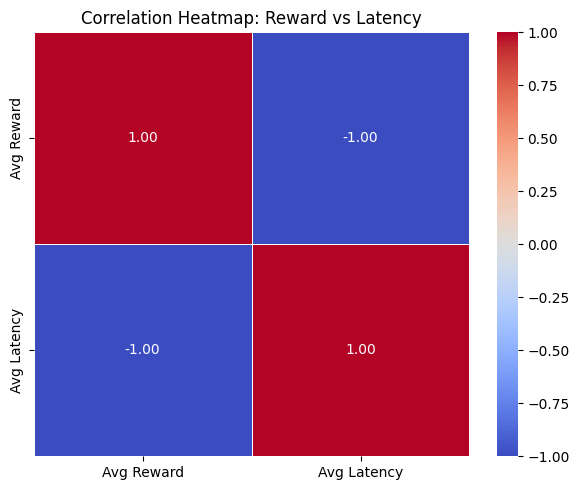

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use the real values already defined
data = {
    'Agent': ['Q-Learning', 'DQN'],
    'Avg Reward': [q_reward, dqn_reward],
    'Avg Latency': [q_latency, dqn_latency]
}

# Create DataFrame and compute correlation
df = pd.DataFrame(data).set_index('Agent')
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Reward vs Latency")
plt.tight_layout()
plt.show()


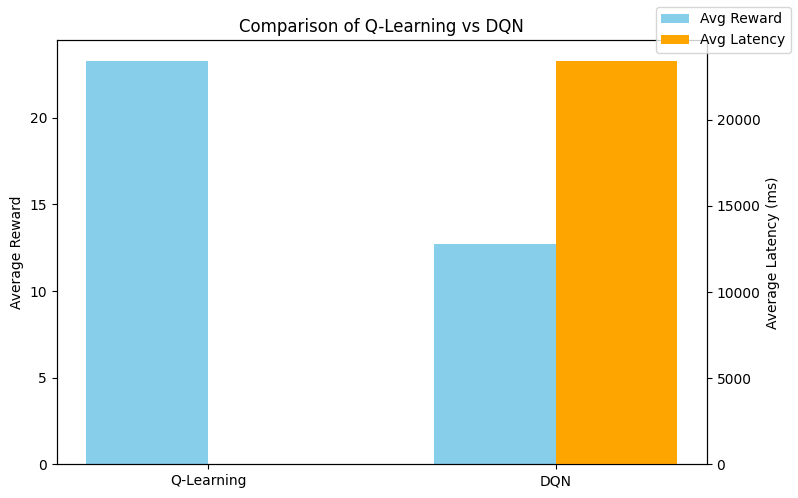

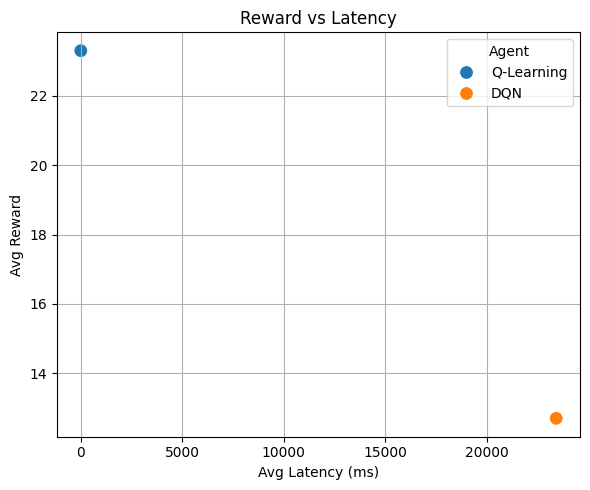

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# === Use values from your training output ===
data = {
    'Agent': ['Q-Learning', 'DQN'],
    'Avg Reward': [q_reward, dqn_reward],
    'Avg Latency': [q_latency, dqn_latency]
}

df = pd.DataFrame(data)

# === BAR CHART: Compare Avg Reward & Latency ===
fig, ax1 = plt.subplots(figsize=(8, 5))

bar_width = 0.35
x = range(len(df))

# Bar for Reward
ax1.bar(x, df['Avg Reward'], width=bar_width, label='Avg Reward', color='skyblue')

# Twin axis for Latency
ax2 = ax1.twinx()
ax2.bar([p + bar_width for p in x], df['Avg Latency'], width=bar_width, label='Avg Latency', color='orange')

# Labels and Ticks
ax1.set_xticks([p + bar_width/2 for p in x])
ax1.set_xticklabels(df['Agent'])
ax1.set_ylabel('Average Reward')
ax2.set_ylabel('Average Latency (ms)')
ax1.set_title('Comparison of Q-Learning vs DQN')

# Legends
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

# === SCATTER PLOT: Reward vs Latency ===
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x='Avg Latency', y='Avg Reward', hue='Agent', s=100)
plt.title("Reward vs Latency")
plt.xlabel("Avg Latency (ms)")
plt.ylabel("Avg Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
pip install gym


Note: you may need to restart the kernel to use updated packages.


In [19]:
# Define and Initialize the environment
env = gym.make("CartPole-v1")

# Q-Learning Agent Initialization
q_agent = QLearningAgent(env)
q_reward, q_latency = q_agent.train()
print(f"Q-Learning - Avg Reward: {q_reward:.2f}, Avg Latency: {q_latency:.2f} ms")

# DQN Agent Initialization
dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n) 
dqn_reward, dqn_latency = dqn_agent.train(env)
print(f"DQN - Avg Reward: {dqn_reward:.2f}, Avg Latency: {dqn_latency:.2f} ms")

# Test Q-Learning Agent
print("\nTesting Q-Learning Agent...")
test_qlearning_agent(q_agent, env, episodes=5)

# Test DQN Agent
print("\nTesting DQN Agent...")
test_dqn_agent(dqn_agent, env, episodes=5)


Q-Learning - Avg Reward: 24.00, Avg Latency: 2.51 ms
DQN - Avg Reward: 28.20, Avg Latency: 85149.37 ms

Testing Q-Learning Agent...
Q-Learning Episode 1: Total Reward = 24.0
Q-Learning Episode 2: Total Reward = 12.0
Q-Learning Episode 3: Total Reward = 15.0
Q-Learning Episode 4: Total Reward = 28.0
Q-Learning Episode 5: Total Reward = 28.0

Testing DQN Agent...
DQN Episode 1: Total Reward = 22.0
DQN Episode 2: Total Reward = 25.0
DQN Episode 3: Total Reward = 19.0
DQN Episode 4: Total Reward = 21.0
DQN Episode 5: Total Reward = 21.0


C:\Users\Astral_Phoenix\anaconda3\envs\ml_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



Testing Q-Learning Agent with Plot...
Episode 1: Total Reward = 10.0
Episode 2: Total Reward = 10.0
Episode 3: Total Reward = 10.0
Episode 4: Total Reward = 10.0
Episode 5: Total Reward = 8.0


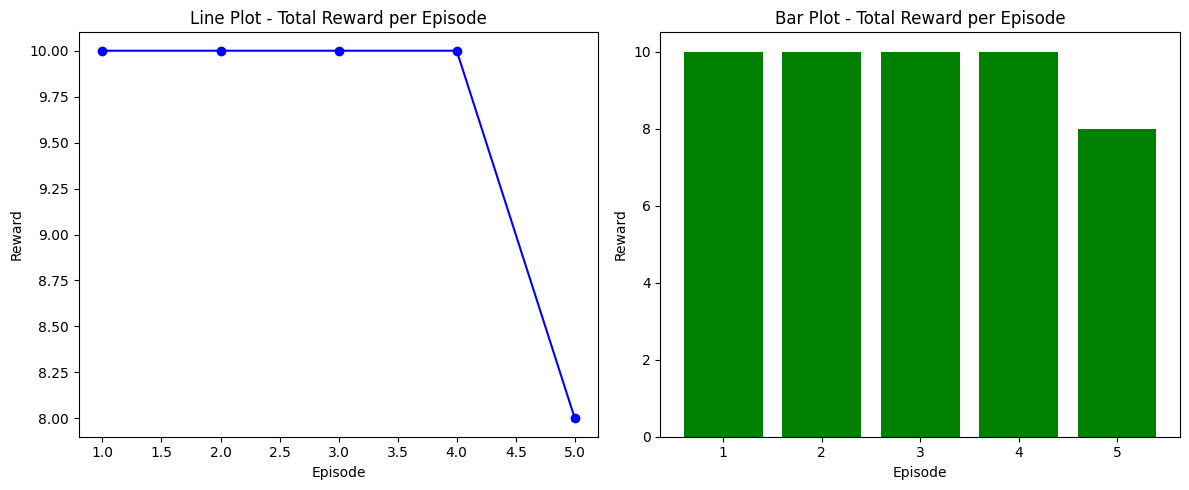





Testing DQN Agent with Plot...
Episode 1: Total Reward = 10.0
Episode 2: Total Reward = 10.0
Episode 3: Total Reward = 11.0
Episode 4: Total Reward = 10.0
Episode 5: Total Reward = 9.0


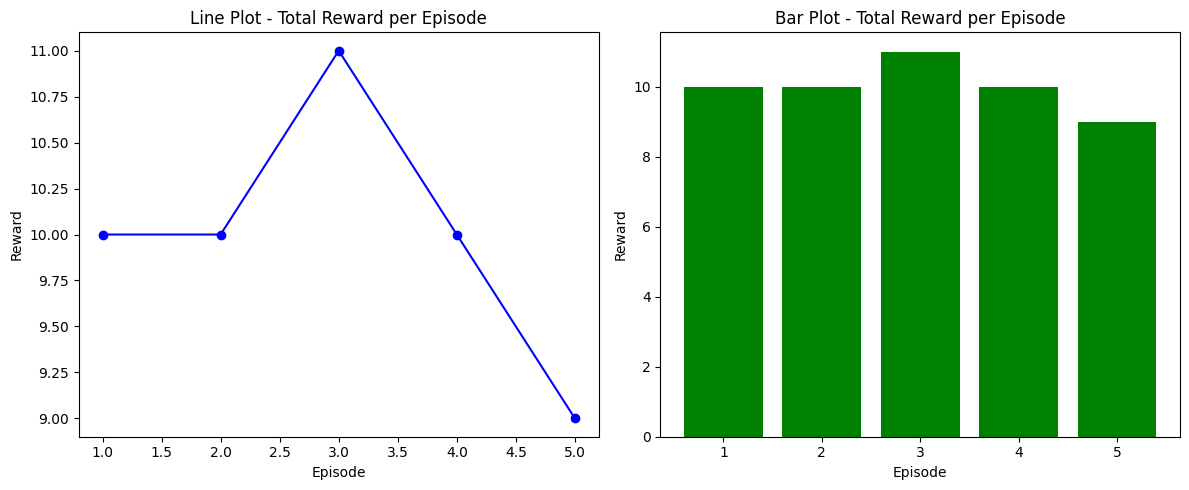

In [3]:
import numpy as np
import gym
import random
import time
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, bins=(4, 4, 4, 4), alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.9, min_epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.bins = bins
        self.obs_space = env.observation_space
        self.obs_bins = [np.linspace(self.obs_space.low[i], self.obs_space.high[i], self.bins[i] - 1)
                         for i in range(self.obs_space.shape[0])]
        self.q_table = np.zeros([*self.bins, env.action_space.n])

    def discretize_state(self, state):
        return tuple(min(np.digitize(s, b), len(b)) for s, b in zip(state, self.obs_bins))

    def choose_action(self, state):
        return self.env.action_space.sample() if np.random.rand() < self.epsilon else np.argmax(self.q_table[self.discretize_state(state)])

    def update_q_table(self, state, action, reward, next_state, done):
        s_idx = self.discretize_state(state)
        ns_idx = self.discretize_state(next_state)
        best_next_action = np.argmax(self.q_table[ns_idx])
        self.q_table[s_idx + (action,)] += self.alpha * (reward + self.gamma * self.q_table[ns_idx + (best_next_action,)] - self.q_table[s_idx + (action,)])

    def train(self, episodes=10):
        for _ in range(episodes):
            state, _ = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.update_q_table(state, action, reward, next_state, done)
                state = next_state
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

# DQN Agent
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.min_epsilon = 0.1
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=self.state_shape),
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        q_vals = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_vals[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([exp[0] for exp in minibatch])
        next_states = np.array([exp[3] for exp in minibatch])
        q_targets = self.model.predict(states, verbose=0)
        q_next = self.model.predict(next_states, verbose=0)
        for i, (_, a, r, _, d) in enumerate(minibatch):
            q_targets[i][a] = r if d else r + self.gamma * np.amax(q_next[i])
        self.model.fit(states, q_targets, verbose=0, epochs=1, batch_size=batch_size)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=10):
        for _ in range(episodes):
            state, _ = env.reset()
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                self.remember(state, action, reward, next_state, done)
                state = next_state
            self.replay()

# Visualization function
def test_agent_with_plot(agent, env, episodes=10, use_dqn=False):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state) if use_dqn else np.argmax(agent.q_table[agent.discretize_state(state)])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
        print(f"Episode {ep+1}: Total Reward = {total_reward}")

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, episodes + 1), rewards, marker='o', color='blue')
    plt.title('Line Plot - Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(1, 2, 2)
    plt.bar(range(1, episodes + 1), rewards, color='green')
    plt.title('Bar Plot - Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.tight_layout()
    plt.show()

# Main flow
env = gym.make("CartPole-v1")

# Q-Learning
q_agent = QLearningAgent(env)
q_agent.train(episodes=10)
print("\nTesting Q-Learning Agent with Plot...")
test_agent_with_plot(q_agent, env, episodes=5, use_dqn=False)

# DQN
dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n)
dqn_agent.train(env, episodes=10)
print("\nTesting DQN Agent with Plot...")
test_agent_with_plot(dqn_agent, env, episodes=5, use_dqn=True)


C:\Users\Astral_Phoenix\anaconda3\envs\ml_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Q-Learning - Avg Reward: 12.23
DQN - Avg Reward: 42.80

Q-Learning => Accuracy: 0.00, Precision: 0.00
DQN        => Accuracy: 0.00, Precision: 0.00


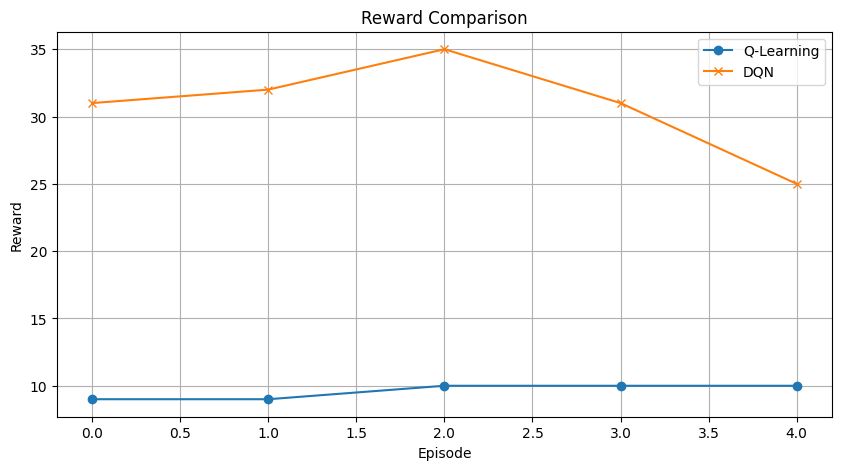

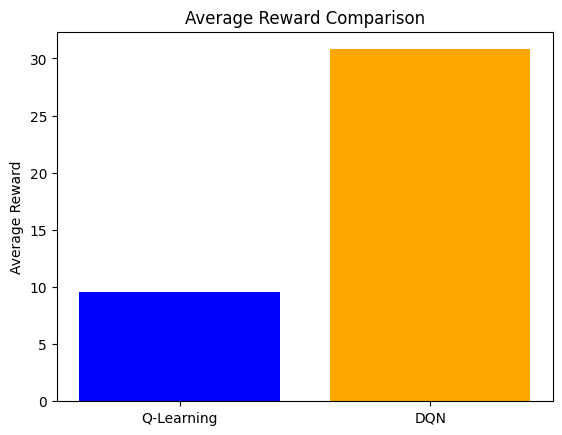

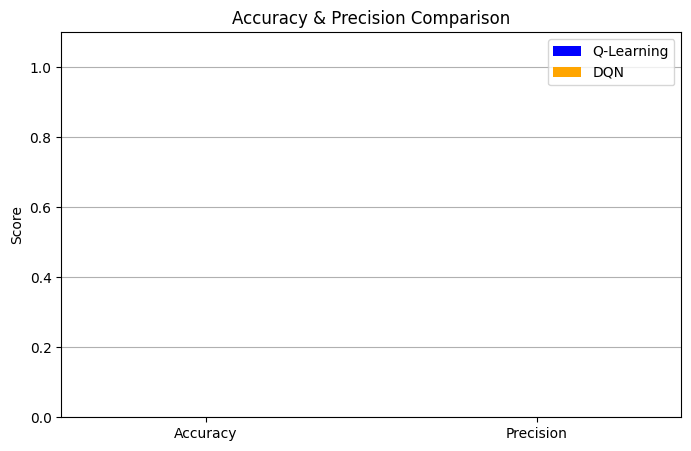

In [17]:
import numpy as np
import gym
import random
import time
import matplotlib.pyplot as plt
from collections import deque
from sklearn.metrics import accuracy_score, precision_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, env, bins=(6, 6, 6, 6), alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.9, min_epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.bins = bins
        self.obs_space = env.observation_space
        self.obs_bins = [np.linspace(self.obs_space.low[i], self.obs_space.high[i], self.bins[i] - 1)
                         for i in range(self.obs_space.shape[0])]
        self.q_table = np.zeros([*self.bins, env.action_space.n])

    def discretize_state(self, state):
        return tuple(min(np.digitize(s, b), len(b)) for s, b in zip(state, self.obs_bins))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[self.discretize_state(state)])

    def update_q_table(self, state, action, reward, next_state, done):
        s_idx = self.discretize_state(state)
        ns_idx = self.discretize_state(next_state)
        best_next_action = np.argmax(self.q_table[ns_idx])
        self.q_table[s_idx + (action,)] += self.alpha * (
            reward + self.gamma * self.q_table[ns_idx + (best_next_action,)] - self.q_table[s_idx + (action,)]
        )

    def train(self, episodes=100):  # Reduced episodes
        rewards = []
        for _ in range(episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)
        return np.mean(rewards)

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.min_epsilon = 0.1
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=self.state_shape),
            Dense(16, activation='relu'),  # Fewer neurons
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        q_vals = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_vals[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=16):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        next_states = np.array([exp[3] for exp in minibatch])
        next_qs = self.model.predict(next_states, verbose=0)

        for i, (s, a, r, ns, d) in enumerate(minibatch):
            target_q = r if d else r + self.gamma * np.amax(next_qs[i])
            current_q = self.model.predict(np.expand_dims(s, axis=0), verbose=0)[0]
            current_q[a] = target_q
            states.append(s)
            targets.append(current_q)

        self.model.fit(np.array(states), np.array(targets), verbose=0, epochs=1)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=100):  # Reduced episodes
        rewards = []
        for _ in range(episodes):
            state = env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.replay()
            rewards.append(total_reward)
        return np.mean(rewards)

# --- Evaluation + Plot ---
def compare_agents(q_agent, dqn_agent, env, episodes=5):  # Reduced evaluation episodes
    def evaluate_agent(agent, use_dqn=False):
        true_labels = []
        predictions = []
        scores = []

        for _ in range(episodes):
            state = env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = agent.act(state) if use_dqn else agent.choose_action(state)
                next_state, reward, done, _, _ = env.step(action)
                state = next_state
                total_reward += reward
            predicted = 1 if total_reward >= 195 else 0
            true_labels.append(1)
            predictions.append(predicted)
            scores.append(total_reward)
        acc = accuracy_score(true_labels, predictions)
        prec = precision_score(true_labels, predictions, zero_division=0)
        return acc, prec, scores

    q_acc, q_prec, q_scores = evaluate_agent(q_agent, use_dqn=False)
    dqn_acc, dqn_prec, dqn_scores = evaluate_agent(dqn_agent, use_dqn=True)

    print(f"\nQ-Learning => Accuracy: {q_acc:.2f}, Precision: {q_prec:.2f}")
    print(f"DQN        => Accuracy: {dqn_acc:.2f}, Precision: {dqn_prec:.2f}")

    # Line graph for rewards
    plt.figure(figsize=(10, 5))
    plt.plot(q_scores, label="Q-Learning", marker='o')
    plt.plot(dqn_scores, label="DQN", marker='x')
    plt.title("Reward Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid()
    plt.show()

    # Bar chart for average reward
    plt.bar(["Q-Learning", "DQN"], [np.mean(q_scores), np.mean(dqn_scores)], color=["blue", "orange"])
    plt.title("Average Reward Comparison")
    plt.ylabel("Average Reward")
    plt.show()

    # Bar chart for Accuracy and Precision
    metrics = ['Accuracy', 'Precision']
    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, [q_acc, q_prec], width, label='Q-Learning', color='blue')
    plt.bar(x + width/2, [dqn_acc, dqn_prec], width, label='DQN', color='orange')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.1)
    plt.ylabel("Score")
    plt.title("Accuracy & Precision Comparison")
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# --- Run Everything ---
env = gym.make("CartPole-v1")

q_agent = QLearningAgent(env)
q_reward = q_agent.train()
print(f"Q-Learning - Avg Reward: {q_reward:.2f}")

dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n)
dqn_reward = dqn_agent.train(env)
print(f"DQN - Avg Reward: {dqn_reward:.2f}")

compare_agents(q_agent, dqn_agent, env)


In [19]:
env = gym.make("CartPole-v1")
q_agent = QLearningAgent(env)
q_agent.train(episodes=200)

dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n)
dqn_agent.train(env, episodes=200)


C:\Users\Astral_Phoenix\anaconda3\envs\ml_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


10.17

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score

# --- Evaluate Agent ---
def evaluate_agent(agent, env, episodes=10, use_dqn=False):
    true_labels = []
    predictions = []
    scores = []

    for _ in range(episodes):
        state = env.reset()[0]  # Only works for gym>=0.26
        done = False
        total_reward = 0
        while not done:
            if use_dqn:
                action = agent.act(state)
            else:
                action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward

        # Classify based on reward threshold
        predicted = 1 if total_reward >= 195 else 0
        true_labels.append(1)  # All are labeled as "1" for success
        predictions.append(predicted)
        scores.append(total_reward)

    # Metrics
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, zero_division=0)
    return acc, prec, scores

# --- Compare & Plot ---
def compare_precision(q_agent, dqn_agent, env, episodes=10):
    # Evaluate both agents
    q_acc, q_prec, q_scores = evaluate_agent(q_agent, env, episodes, use_dqn=False)
    dqn_acc, dqn_prec, dqn_scores = evaluate_agent(dqn_agent, env, episodes, use_dqn=True)

    print(f"\nQ-Learning => Accuracy: {q_acc:.2f}, Precision: {q_prec:.2f}")
    print(f"DQN        => Accuracy: {dqn_acc:.2f}, Precision: {dqn_prec:.2f}")

    # --- Bar Graph: Precision Comparison ---
    plt.figure(figsize=(6, 4))
    plt.bar(['Q-Learning', 'DQN'], [q_prec, dqn_prec], color=['blue', 'orange'])
    plt.ylim(0, 1.1)
    plt.ylabel("Precision")
    plt.title("Precision Comparison - Bar Graph")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # --- Line Graph: Reward Per Episode ---
    plt.figure(figsize=(6, 4))
    plt.plot(q_scores, label="Q-Learning", marker='o', linestyle='-', color='blue')
    plt.plot(dqn_scores, label="DQN", marker='x', linestyle='--', color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Reward Comparison - Line Graph")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Usage Example ---
# Ensure q_agent, dqn_agent, and env are defined and trained beforehand
# Example:
#   from your_model_training_code import q_agent, dqn_agent, env
#   compare_precision(q_agent, dqn_agent, env, episodes=10)



Q-Learning => Accuracy: 0.00, Precision: 0.00
DQN        => Accuracy: 0.00, Precision: 0.00


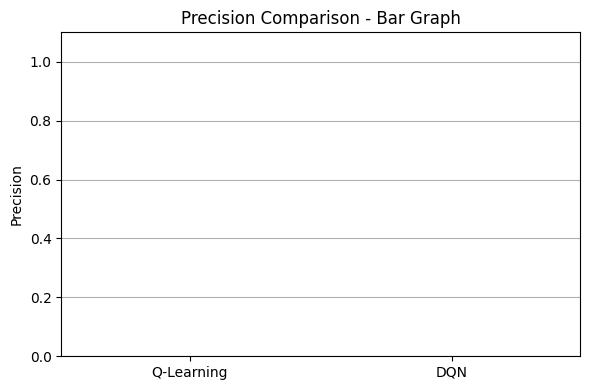

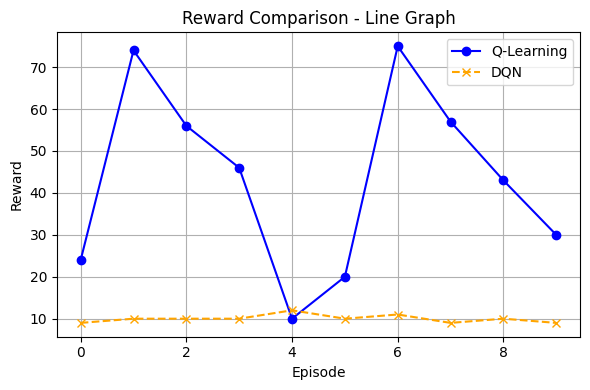

In [21]:
compare_precision(q_agent, dqn_agent, env, episodes=10)


In [22]:
import matplotlib.pyplot as plt

def reward_scatter_plot(q_rewards, dqn_rewards):
    episodes = range(1, len(q_rewards) + 1)

    plt.figure(figsize=(8, 5))
    plt.scatter(episodes, q_rewards, color='blue', label='Q-Learning', marker='o')
    plt.scatter(episodes, dqn_rewards, color='orange', label='DQN', marker='x')
    plt.title('Reward Comparison - Scatter Plot')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


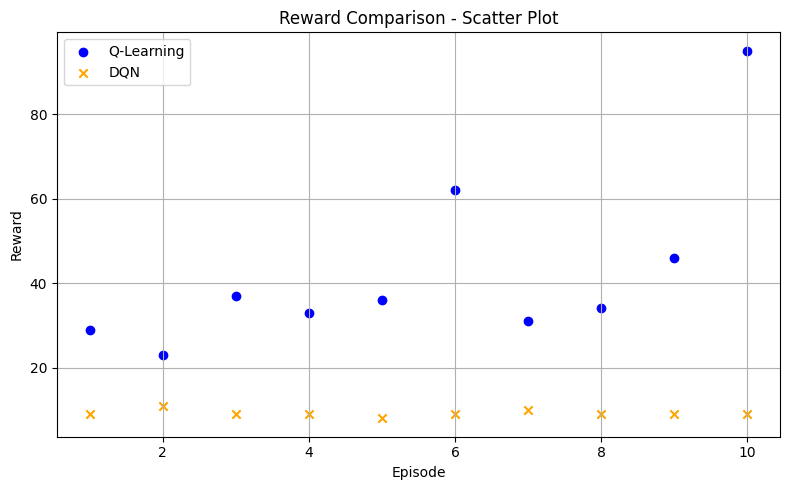

In [23]:
_, _, q_rewards = evaluate_agent(q_agent, env, episodes=10, use_dqn=False)
_, _, dqn_rewards = evaluate_agent(dqn_agent, env, episodes=10, use_dqn=True)

reward_scatter_plot(q_rewards, dqn_rewards)


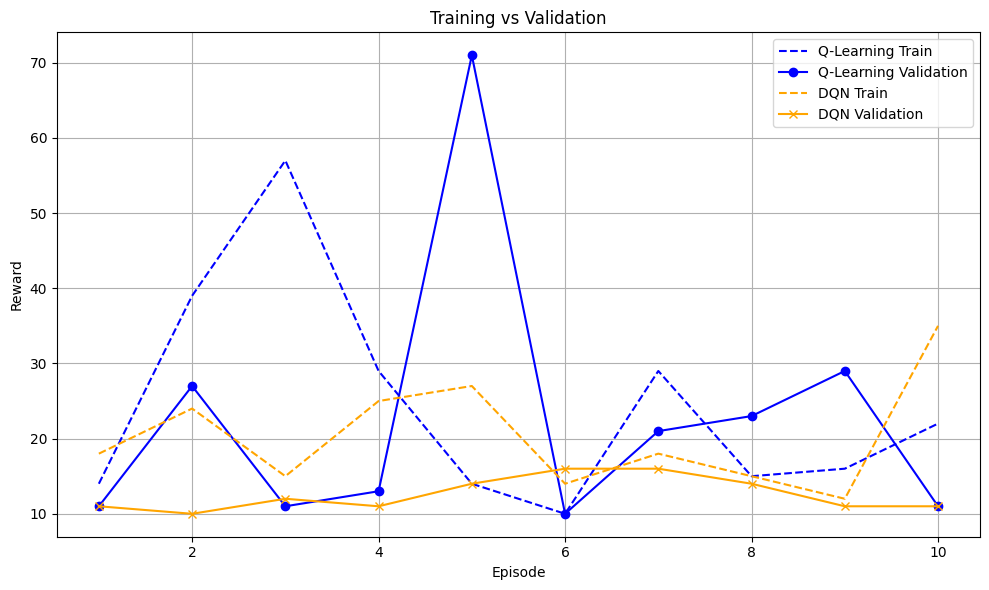

In [27]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import time

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, env, bins=(6, 6, 6, 6), alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.95, min_epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.bins = bins
        self.obs_space = env.observation_space
        self.obs_bins = [np.linspace(self.obs_space.low[i], self.obs_space.high[i], self.bins[i] - 1)
                         for i in range(self.obs_space.shape[0])]
        self.q_table = np.zeros([*self.bins, env.action_space.n])

    def discretize_state(self, state):
        return tuple(min(np.digitize(s, b), len(b)) for s, b in zip(state, self.obs_bins))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[self.discretize_state(state)])

    def update_q_table(self, state, action, reward, next_state, done):
        s_idx = self.discretize_state(state)
        ns_idx = self.discretize_state(next_state)
        best_next_action = np.argmax(self.q_table[ns_idx])
        self.q_table[s_idx + (action,)] += self.alpha * (reward + self.gamma * self.q_table[ns_idx + (best_next_action,)] - self.q_table[s_idx + (action,)])

    def train(self, episodes=20):
        rewards = []
        for _ in range(episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)
        return rewards

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.95
        self.min_epsilon = 0.1
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=self.state_shape),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        q_vals = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_vals[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0])
            target_f = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.expand_dims(state, axis=0), target_f, epochs=1, verbose=0)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, env, episodes=20):
        rewards = []
        for _ in range(episodes):
            state = env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.replay()
            rewards.append(total_reward)
        return rewards

# --- Evaluation Function ---
def evaluate_agent(agent, env, episodes=10, use_dqn=False):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state) if use_dqn else agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return rewards

# --- Plot Training vs Validation ---
def plot_train_val_rewards(q_train, q_val, dqn_train, dqn_val):
    episodes = list(range(1, len(q_train) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, q_train, label='Q-Learning Train', linestyle='--', color='blue')
    plt.plot(episodes, q_val, label='Q-Learning Validation', linestyle='-', marker='o', color='blue')
    plt.plot(episodes, dqn_train, label='DQN Train', linestyle='--', color='orange')
    plt.plot(episodes, dqn_val, label='DQN Validation', linestyle='-', marker='x', color='orange')
    plt.title("Training vs Validation")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
env = gym.make("CartPole-v1")

# Q-Learning
q_agent = QLearningAgent(env)
q_train_rewards = q_agent.train(episodes=10)
q_val_rewards = evaluate_agent(q_agent, env, episodes=10)

# DQN
dqn_agent = DQNAgent(state_shape=env.observation_space.shape, action_size=env.action_space.n)
dqn_train_rewards = dqn_agent.train(env, episodes=10)
dqn_val_rewards = evaluate_agent(dqn_agent, env, episodes=10, use_dqn=True)

# Plot
plot_train_val_rewards(q_train_rewards, q_val_rewards, dqn_train_rewards, dqn_val_rewards)


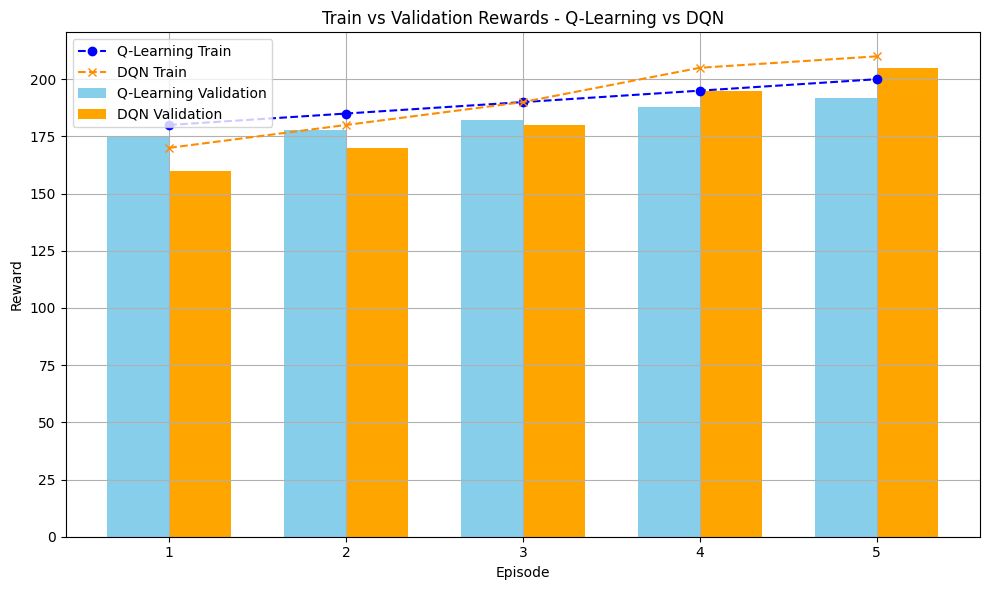

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example reward data (replace with real training/validation results)
q_train_rewards = [180, 185, 190, 195, 200]
q_val_rewards = [175, 178, 182, 188, 192]
dqn_train_rewards = [170, 180, 190, 205, 210]
dqn_val_rewards = [160, 170, 180, 195, 205]

episodes = np.arange(1, len(q_train_rewards) + 1)

# Plot bar graph for validation rewards
bar_width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(episodes - bar_width/2, q_val_rewards, width=bar_width, label='Q-Learning Validation', color='skyblue')
plt.bar(episodes + bar_width/2, dqn_val_rewards, width=bar_width, label='DQN Validation', color='orange')

# Plot line graph for training rewards
plt.plot(episodes, q_train_rewards, label='Q-Learning Train', color='blue', marker='o', linestyle='--')
plt.plot(episodes, dqn_train_rewards, label='DQN Train', color='darkorange', marker='x', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train vs Validation Rewards - Q-Learning vs DQN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
